# Multiclass Adam (and SGD) on a general problem class

#### Notes
 
 - I super recommend using a GPU to run this, otherwise it's slow.
 - Code currently can't handle a non-diagonal data covariance for Adam. The "gradient noise term" isn't calculated correctly (It gets much more expensive). TODO
 - If Adam looks bad increase the "history_length" and "num_samples" values in the "compute_phi..." and "compute_cov.." functions. These control and approximation quality

100%|██████████| 12000/12000 [00:05<00:00, 2058.39it/s]


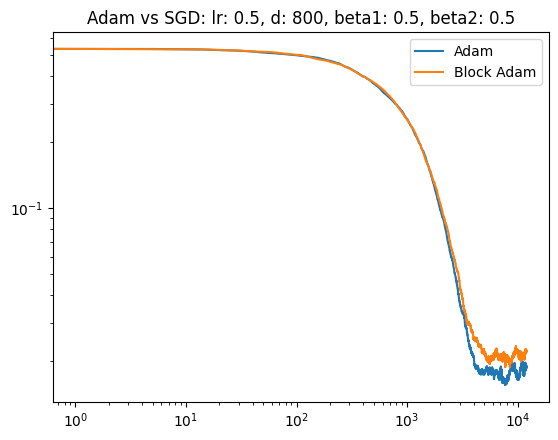

In [ ]:
from sdes import AdamSDE, SgdSDE
from odes import AdamODE, SgdODE
from optimizers import Adam, SGD, ResampledAdam, BlockAdam

import jax
import jax.numpy as jnp
from jax.numpy.linalg import norm
import numpy as np
import matplotlib.pyplot as plt
import scipy
# jax.config.update("jax_log_compiles", True)

# Setup the problem and parameters
problem_type = 'linreg' # from  'logreg' or 'linreg', 'real_phase_ret'

d = 800 # dimension
m = 1 # number of classes (target dimension)
beta1 = 0.5  # caution setting these values above 0.9 or so without increasing "history_length" 
beta2 = 0.5
eps = 0
T = 15 # time to run SDE for

lr = 0.5 # SDE learning rate
lrk = lr / d # Optimzer learning rate

# lr = lambda x: jnp.cos(2 * x / T) # SDE learning rate
# lrk = lambda x: jnp.cos(2 * x / T / d) / d # Optimizer learning rate

cov_diag = jnp.linspace(0.1, 1, d) # initialize with diagonal covariance
cov = cov_diag
# cov = jnp.array([j**(-0.5) for j in range(1, d+1)])
# cov = jnp.ones(d)
# U = scipy.linalg.orth(np.random.normal(size=(d, d)))
# cov = U @ jnp.diag(cov_diag) @ U.T
# cov = jnp.diag(cov_diag) 

# rho = 0.1
# J = jnp.ones((d, d))
# cov = (1 - rho) * jnp.eye(d) + rho * J
# cov_diag = jnp.diag(cov)

# cov = np.random.randn(d, d * 2)
# cov = cov @ cov.T


key = jax.random.PRNGKey(np.random.randint(0, 10000))
key_init, key_opt, key = jax.random.split(key, 3)

key_init = jax.random.PRNGKey(1331)
key_opt = jax.random.PRNGKey(1331//2)
params0 = jax.random.normal(key_init, (d,m))
# params0 = jnp.ones((d,m)) * 0.5
# optimal_params = params0 + 0.1*jax.random.normal(key_opt, (d,m))
optimal_params = jax.random.normal(key_opt, (d,m))
# optimal_params = jnp.zeros_like(params0)

# params0 = jnp.linspace(0.1, 1, d).reshape((d,1))
# optimal_params = jnp.ones((d,m)) * 3



params0 /= norm(params0, axis = 0)
optimal_params /= norm(optimal_params, axis = 0)
# optimal_params *= 5

# Run the ODE equivalents
adam_ode = AdamODE(problem_type)
# sgd_ode = SgdODE(problem_type)

dt = 0.01
num_samples = 300
# adam_risk, adam_time, B = adam_ode.run(params0, optimal_params, cov, T, lr, dt = dt, beta1 = beta1, beta2 = beta2, eps = eps, num_samples = num_samples)


# adam_risk_diag, adam_time, B = adam_ode.run(params0, optimal_params, cov_diag, T, lr, dt = dt, beta1 = beta1, beta2 = beta2, eps = eps, num_samples = num_samples)
# sgd_risk, sgd_time, B = sgd_ode.run(params0, optimal_params, cov, T, lr, dt = dt * 2)


# Run the optimizers
adam = Adam(problem_type)
block_adam = BlockAdam(problem_type)
resampled_adam = ResampledAdam(problem_type)
sgd = SGD(problem_type)

# _, resampled_adam_risks = resampled_adam.run(params0, cov, T, lrk, optimal_params, beta1 = beta1, beta2 = beta2, eps = eps)
# _, sgd_risks = sgd.run(params0, cov, T, lrk, optimal_params)
_, block_adam_risks = block_adam.run(params0, cov, T, lrk, optimal_params, beta1 = beta1, beta2 = beta2, eps = eps)
opt_p, adam_risks = adam.run(params0, cov, T, lrk, optimal_params, beta1 = beta1, beta2 = beta2, eps = eps)
# _, adam_risks_beta0 = adam.run(params0, cov, T, lrk, optimal_params, beta1 = 0, beta2 = beta2, eps = eps)

# Run the SDE equivalents
sgd_sde = SgdSDE(problem_type)
adam_sde = AdamSDE(problem_type)

# _, sgd_sde_risks, times_s = sgd_sde.run(params0, optimal_params, cov, T, lr)
# params, adam_sde_risks, times_s = adam_sde.run(params0, optimal_params, cov, T, lr, beta1 = beta1, beta2 = beta2, )



plt.yscale('log')
# plt.xscale('log')
plt.plot(adam_risks, label = 'Adam')
plt.plot(block_adam_risks, label = 'Block Adam')
# plt.plot(resampled_adam_risks, label = 'Resampled Adam', ls = ':')
# plt.plot(adam_risks_beta0, label = 'Adam beta1=0')
# plt.plot(sgd_risks, label = 'SGD')

# plt.plot(times_s * d, adam_sde_risks, label = 'Adam SDE')
# plt.plot(times_s * d, sgd_sde_risks, label = 'SGD SDE')

# plt.plot(adam_time * d, adam_risk, label = 'Adam ODE')
# plt.plot(adam_time * d, adam_risk_diag, label = 'Adam ODE Diagonal')
# plt.plot(sgd_time * d, sgd_risk, label = 'SGD ODE')
plt.title(f'Adam vs SGD: lr: {lr}, d: {d}, beta1: {beta1}, beta2: {beta2}')
plt.legend()
plt.show()

In [5]:
block_adam.step

AttributeError: 'BlockAdam' object has no attribute 'step'